In [216]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

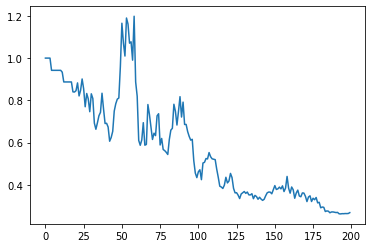

In [234]:
def e_detector_sr(data, lmbda):
    N = len(data)
    E = np.zeros((N, N))
    for j in range(N):
        for i in range(j, N):
            l = max(lmbda, (np.sum(data[j:i])+lmbda)/(i-j+1))
            if i == 0 and j == 0:
                E[j, i] = np.exp(data[i] * np.log(l / lmbda) - l + lmbda)
            else:
                E[j, i] = E[j, i - 1] * np.exp( data[i] * np.log(l / lmbda) - l + lmbda)
    return np.sum(E, axis=0)

data = np.random.poisson(300, 200)

plt.plot(e_detector_sr(data, 300))
plt.show()

/Users/aytijhyasaha/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aytijhyasaha/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


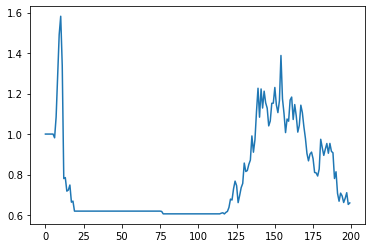

In [220]:
def e_detector_cusum(data, lmbda):
    N = len(data)
    E = np.zeros((N, N))
    for j in range(N):
        for i in range(j, N):
            l = max(lmbda, np.mean(data[j:i]))
            if i == 0 and j == 0:
                E[j, i] = np.exp(data[i] * np.log(l / lmbda) - l + lmbda)
            else:
                E[j, i] = E[j, i - 1] * np.exp(data[i] * np.log(l / lmbda) - l + lmbda)
    return np.max(E, axis=0)

data = np.random.poisson(300, 200)

plt.plot(e_detector_cusum(data, 300))
plt.show()

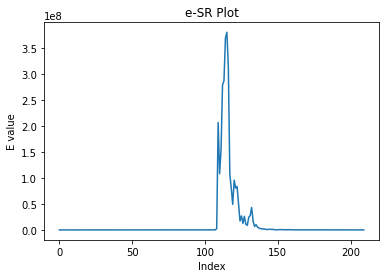

In [223]:
data = np.concatenate((np.random.poisson(30, 100), np.random.poisson(80, 10), np.random.poisson(30, 100)))

plt.plot(e_detector_sr(data, 30))
plt.xlabel("Index")
plt.ylabel("E value")
plt.title("e-SR Plot")
plt.show()

In [224]:
model_ids = ['180703949','170803729','140624423']
#parameters
num = 0
model_id = model_ids[num]
fluences=np.arange(start=0, stop=351, step=10)
hmax=256
bin_width=0.05
fluences
fluence=1000
data = pd.read_csv("simulations.csv", index_col="time") #contains simulations of each burst containing 10000 photons

#plt.savefig(f'plots/grb{num}_pic.png', dpi=150)

Text(0.5, 1.0, 'Simulation of GRB 180703949 with photon count 1000')

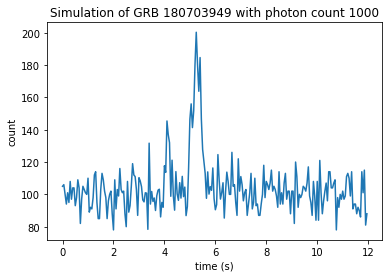

In [225]:
background = data['background']
burst_shape = data[model_id]
grb = background + fluence/100000 * burst_shape #rescaled model of burst with background
grb.plot()
plt.xlabel('time (s)')
plt.ylabel('count')
plt.title(f'Simulation of GRB {model_id} with photon count {fluence}')

In [226]:
sr = np.zeros((17, 3))
cusum = np.zeros((17, 3))
id_vals = np.arange(0, 161, 10)

for i in range(17):
    for j in range(3):
        grb = data['background'] + id_vals[i] / 100000 * data[model_ids[j]]
        cusum[i, j] = np.max(e_detector_cusum(np.array(grb), 100))
        sr[i, j] = np.max(e_detector_sr(np.array(grb), 100))



/Users/aytijhyasaha/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aytijhyasaha/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [227]:
def binning(data, bin_width=0.05):
    grb_counts = pd.DataFrame(data)
    grb_counts[0] = grb_counts[0]-grb_counts.loc[0, 0]
    first = 0; last = grb_counts.iloc[-1, 0]

    bins = np.arange(first, last+bin_width, bin_width)
    bin_map = pd.cut(grb_counts[0], bins=bins).apply(lambda I: I.left)
    bin_series = pd.DataFrame(bin_map).groupby(0)[0].count()
    bin_df = pd.DataFrame({'count':bin_series})
    return bin_df

def window_detection(signal, λ, σ=5, hmax=128, spacing='logarithmic'):

    if spacing=='logarithmic':
        window_lengths = 2**(np.arange(0, np.ceil(np.log2(hmax)))).astype(int)
    else:
        window_lengths = np.arange(1, hmax+1)

    max_threshold=0
    best_window=1

    for h in window_lengths:

        data = signal.rolling(window=h).mean()
        μ = data/λ

        lr_statistic = 2*h*λ*(μ*np.log(μ)-μ+1) * (μ>1)


        if lr_statistic.max() > max_threshold:
            max_threshold = lr_statistic.max()
            best_window=h

    sigma_level = np.sqrt(max_threshold*2)
    return sigma_level

In [228]:
def window_detection(signal, λ, hmax=128, spacing='logarithmic'):

    if hmax==None:
        hmax=len(signal)

    if spacing=='logarithmic':
        window_lengths = 2**(np.arange(0, np.ceil(np.log2(hmax)))).astype(int)
    else:
        window_lengths = np.arange(1, hmax+1)

    max_threshold=0
    best_window=1

    output=pd.DataFrame()

    for h in window_lengths:

        data = pd.Series(signal).rolling(window=h).mean()
        μ = data/λ

        lr_statistic = 2*h*λ*(μ*np.log(μ)-μ+1) * (μ>1)
        sigma_level = np.sqrt(lr_statistic)
        output[f'{h}'] = sigma_level

    max_sigma = output.max(axis='columns')

    return max_sigma

In [43]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import math

In [196]:
sigma_levels = np.linspace(4, 5, 11)
λ = 100
runs = range(500)
size=20000



data_all=pd.DataFrame(index=sigma_levels, columns=runs)
for run in runs:
    #np.random.seed(run)
    signal = stats.poisson(mu=λ).rvs(size)
    significance = window_detection(signal, λ, spacing="all")
    for sigma_level in sigma_levels:
        run_length = np.argmax(significance>sigma_level)
        if run_length == 0:
            run_length = size
        data_all.loc[sigma_level, run] = run_length

data_all["average"] = data_all.mean(axis="columns")

/var/folders/f6/qqs31c0152g5b7yj_v3h8nr80000gn/T/ipykernel_83470/846004385.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  output[f'{h}'] = sigma_level


In [197]:
print(data_all["average"])

4.0     5702.262
4.1     7866.950
4.2    10097.366
4.3    12615.920
4.4    14784.526
4.5    16117.270
4.6    17414.656
4.7    18396.802
4.8    19065.912
4.9    19373.622
5.0    19576.524
Name: average, dtype: float64


In [172]:
def e_detector_sr_fast(data, lmbda):
    N = len(data)
    E = np.zeros(N)
    sum_data = np.cumsum(data)  # Pre-calculate cumulative sum
    l = max(lmbda, (data[0] + lmbda) / 2)
    E[1]= data[0] * np.log(l / lmbda) - l + lmbda
    for i in range(1,N):
        if i%1000 == 0: print(i)
        x = data[0:i]
        l = np.maximum((np.cumsum(x[::-1]) +1*lmbda) / np.arange(2, len(x)+2),lmbda)
        E[i] = E[i-1] + data[i] * np.sum(np.log(l / lmbda)) - np.sum(l) + i*lmbda
    return E


In [214]:
alpha_levels = np.linspace(20,50, 10)
λ = 100
runs = range(20)
size=1000000



data_esr=pd.DataFrame(index=alpha_levels, columns=runs)
for run in runs:
    np.random.seed(run)
    signal = np.random.poisson(λ, size)
    significance = e_detector_sr_fast(signal, λ)
    for alpha_level in alpha_levels:
        run_length = np.argmax(significance>(alpha_level))
        if run_length == 0:
            run_length = size
        data_esr.loc[alpha_level, run] = run_length

data_esr["average"] = data_esr.mean(axis="columns")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

KeyboardInterrupt: 

In [210]:
print(data_esr["average"])

20.000000    4975.04
20.303030    4976.98
20.606061    4976.98
20.909091    4976.99
21.212121    4977.10
              ...   
48.787879    6041.76
49.090909    6041.76
49.393939    6041.76
49.696970    6041.76
50.000000    6041.76
Name: average, Length: 100, dtype: float64


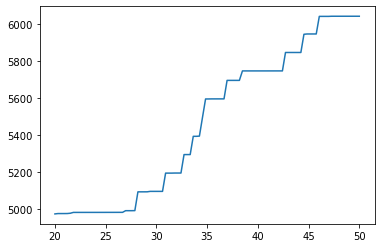

In [211]:
plt.plot(alpha_levels,data_esr["average"])
plt.show()

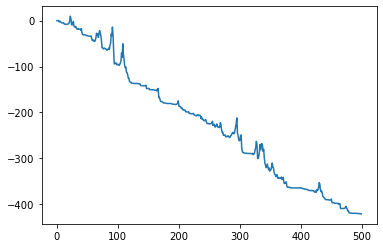

In [183]:
plt.plot(e_detector_sr_fast(data, 100))
plt.show()

In [ ]:
alpha_levels = np.linspace(10**4, 10**6, 20)
λ = 100
runs = range(50)
size=2000000



data_e_cs=pd.DataFrame(index=alpha_levels, columns=runs)
for run in runs:
    np.random.seed(run)
    signal = stats.poisson(mu=λ).rvs(size)
    significance = e_detector_cusum(signal, λ)
    for alpha_level in alpha_levels:
        run_length = np.argmax(significance>alpha_level)
        if run_length == 0:
            run_length = size
        data_e_cs.loc[alpha_level, run] = run_length

data_e_cs["average"] = data_e_cs.mean(axis="columns")

In [231]:
k = np.arange(4, 5.1, 0.1)
arl= data_all["average"]

#arl = np.array([5623.34, 8449.74, 12277.34, 18940.88, 24567.46, 48482.06, 64692.74,108519.70, 171507.50, 278664.94, 405373.90])



# Assuming you have defined rel and focus arrays
#rel = np.interp( output, k, arl)

result = {
    "e-CUSUM": cusum[:, 0],
    "e-SR": sr[:, 0],
    #"FOCuS": np.log(rel)
}

IndexError: single positional indexer is out-of-bounds

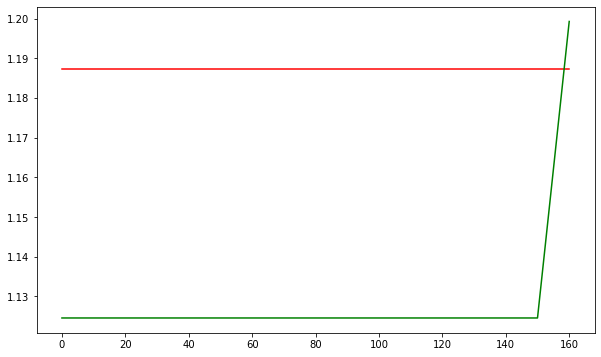

In [233]:
result= pd.DataFrame(result)
plt.figure(figsize=(10, 6))
colors=['r','g']
l=["e-CUSUM","e-SR"]
for i in range(3):
    plt.plot(id_vals,result.iloc[:,i],color=colors[i], label=l[i])

plt.xlabel("Number of photons in burst")
plt.ylabel("log(ARL)")
plt.title("ARL vs Intensity")
plt.legend()
plt.show()
